## Will debiasing one protected attribute A influence debias degree of another attribute B?

In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
#%autoreload

### Data loading

In [2]:
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [3]:
# 150k top vectors (with gender-typical words) - used for training

filter_embed_path = "../data/embeddings/vecs.filtered.txt"
model = KeyedVectors.load_word2vec_format(filter_embed_path)

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

# only gendered vectors
model_gendered, vecs_gendered, words_gendered = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")

In [14]:
#optional
#check words list
def save_wordslist_to_txt(path, words):
    file = open(path, 'w')
    file.write(str(words))
    file.close()
    return None

save_wordslist_to_txt("../data/embeddings/words.filtered.txt", words)
save_wordslist_to_txt("../data/embeddings/words.gendered.txt", words_gendered)

In [25]:
#optional
#delete gender specific
import copy
def del_list_from_list(in_list,del_list):
    res = copy.deepcopy(in_list)
    for word in del_list:
        if word in res:
            res.remove(word)
    return res

#delete gender specific words from filtered words
#https://github.com/tolga-b/debiaswe/blob/master/data/gender_specific_full.json
file_handle =open("../data/from-hard-debias/gender_specific_full.json",mode='r')
words_gen_spec=list(file_handle)
file_handle.close()
words_gen_spec=words_gen_spec[0]
words_gen_spec=eval(words_gen_spec)
print(len(words_gen_spec),len(words),words_gen_spec[0],words_gen_spec[1])#1441 150000 he his
words_deleted_gen_spec=del_list_from_list(words,words_gen_spec)
print(len(words_deleted_gen_spec))#149596

1441 150000 he his


NameError: name 'ptint' is not defined

### Assign direction and labels

In [4]:
#for bi-classes

num_vectors_per_class = 7500

def assign_direction_and_labels(model, pairs, direction, by_pca=False):
    if by_pca:
        vecs = [model[p[0]] - model[p[1]] for p in pairs]
        pca = PCA(n_components=1)
        pca.fit(vecs)
        direction = pca.components_[0]

    gender_unit_vec = direction/np.linalg.norm(direction)
    masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(direction, model, n = num_vectors_per_class)

    masc_words, masc_scores = list(zip(*masc_words_and_scores))
    neut_words, neut_scores = list(zip(*neut_words_and_scores))
    fem_words, fem_scores = list(zip(*fem_words_and_scores))
    masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
    neut_vecs = get_vectors(neut_words, model)

    n = min(3000, num_vectors_per_class)
    all_significantly_biased_words = masc_words[:n] + fem_words[:n]
    all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
    all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                      np.zeros(n, dtype = int)))

    all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
    all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)

    print("TOP class 1")
    print(masc_words[:50])
    print("({},{})".format(masc_scores[0],masc_scores[49]))
    print("-------------------------")
    print("TOP class 0")
    print(fem_words[:50])
    print("({},{})".format(fem_scores[0],fem_scores[49]))
    print("-------------------------")
    print(neut_words[:50])
    print("({},{})".format(neut_scores[0],neut_scores[49]))

    return (masc_vecs, fem_vecs, neut_vecs, \
        all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)


#for 3 class races
def prepare_labels_of_3race(w_vecs, w_labels, b_vecs, b_labels, y_vecs, y_labels):
    np.random.seed(0)
    ind2label =  {1: "caucasian-biased", 2: "african-biased", 3: "asian-biased"}
    #prepare labels
    w_vecs = w_vecs[w_labels == 1]
    b_vecs = b_vecs[b_labels == 1]
    y_vecs = y_vecs[y_labels == 1]
    w_labels = w_labels[w_labels == 1]
    b_labels = b_labels[b_labels == 1]
    y_labels = y_labels[y_labels == 1]
    
    b_labels = b_labels*2
    y_labels = y_labels*3
    
    all_significantly_biased_vecs= np.concatenate((w_vecs, b_vecs, y_vecs))
    all_significantly_biased_labels = np.concatenate((w_labels, b_labels, y_labels))
    all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(all_significantly_biased_vecs, all_significantly_biased_labels)

    return ind2label, all_significantly_biased_vecs, all_significantly_biased_labels
    


def assign_3labels_race(model, by_pca=False):
    pairs_w = [("caucasian", "african"), ("caucasian", "black"), ("white", "african"), ("america", "africa"), ("europe", "africa"),\
           ("caucasian", "asian"), ("white", "asian"), ("america", "asia"),("america", "china"), ("europe", "asia")]
    race_direction_w = model["caucasian"]-(model["african"] + model["asian"])/2

    pairs_b = [("african", "caucasian"), ("black","caucasian"), ("african", "white"), ("africa","america"), ("africa","europe"),\
               ("african", "asian"), ("black", "asian"), ("african", "asia"),("africa", "china"), ("africa", "asia")]
    race_direction_b = model["african"]-(model["caucasian"] + model["asian"])/2

    pairs_y = [("asian", "african"), ("asian", "black"), ("china", "africa"), ("asia", "africa"),\
              ("asian", "caucasian"), ("asian", "white"), ("china","america"), ("asia","europe")]
    race_direction_y = model["asian"]- (model["african"] + model["caucasian"])/2 

    
    #white labels
    white_vecs, nonw_vecs, w_neut_vecs, \
            plot_words_white, plot_vecs_white, plot_labels_white, \
    =assign_direction_and_labels(model, pairs_w, race_direction_w, by_pca)
   
    #train black classifier
    black_vecs, nonb_vecs, b_neut_vecs, \
            plot_words_black, plot_vecs_black, plot_labels_black, \
    =assign_direction_and_labels(model, pairs_b, race_direction_b, by_pca)

    #train yellow classifier
    yellow_vecs, nony_vecs, y_neut_vecs, \
            plot_words_yellow, plot_vecs_yellow, plot_labels_yellow, \
    =assign_direction_and_labels(model, pairs_y, race_direction_y, by_pca)

    #plot prepare
    ind2label_race, all_race_vecs, all_race_labels\
    =prepare_labels_of_3race(plot_vecs_white, plot_labels_white, plot_vecs_black, plot_labels_black, plot_vecs_yellow, plot_labels_yellow)
    
    return white_vecs, black_vecs, yellow_vecs, \
            ind2label_race, all_race_vecs, all_race_labels

### Perform train-dev-test split and debias

In [5]:
n_iter=35

def debias_train(bias1_vecs, bias0_vecs, neut_vecs, n_iter=35):
    random.seed(0)
    np.random.seed(0)

    X = np.concatenate((bias1_vecs, bias0_vecs, neut_vecs), axis = 0)
    #X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
    y_1 = np.ones(bias1_vecs.shape[0], dtype = int)
    y_0 = np.zeros(bias0_vecs.shape[0], dtype = int)
    y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
    #y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
    y = np.concatenate((y_1, y_0, y_neut))
    X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
    X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
    print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))
    
    
    #debias
    bias_clf = LinearSVC
    #bias_clf = SGDClassifier
    #bias_clf = LogisticRegression
    #bias_clf = LinearDiscriminantAnalysis
    #bias_clf = Perceptron

    params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
    params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
    params = params_svc
    #params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
    #params = {}
    min_acc = 0
    is_autoregressive = True
    dropout_rate = 0

    P, rowspace_projs, Ws = debias.get_debiasing_projection(bias_clf, params, n_iter, 300, is_autoregressive, min_acc,
                                        X_train, Y_train, X_dev, Y_dev,
                                           Y_train_main=None, Y_dev_main=None, 
                                            by_class = False, dropout_rate = dropout_rate)
    
#     np.save("P.glove.dim=300.iters=35.npy", P)

    return (P, rowspace_projs, Ws, X_test, Y_test)

### Test the quality of the debiasing. t-SNE & v-measure

In [6]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue", "yellow"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.savefig("embeddings.{}.png".format(title), dpi=600)
  plt.show()
  return vecs_2d

In [7]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2): 
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    

### Collect biased words and labels--Gender; Train 3 classifiers (male, female, neutral)

In [9]:
# pairs_gender = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her")]#original in INLP
pairs_gender = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her"),("boy","girl"), ("man", "woman")]# word list from hard-debiasing 
gender_direction = model["he"]-model["she"] 

#train gender classifier
male_vecs, fem_vecs, g_neut_vecs, \
        plot_gender_words, plot_gender_vecs, plot_gender_labels, \
=assign_direction_and_labels(model, pairs_gender, gender_direction, by_pca=False)

P_g, rowspace_projs_g, Ws_g, X_test_g, Y_test_g = debias_train(male_vecs, fem_vecs, g_neut_vecs)


TOP class 1
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', 'flacco', 'rc', 'eusebius', 'packers', 'lhp', 'homers', 'mitre', 'linebacker', 'rhp', 'manny')
(0.307711660861969,0.24992065131664276)
-------------------------
TOP class 0
('nichole', 'ftv', 'renee', 'sophie', 'christina', 'marie', 'pregnant', 'nicole', 'samantha', 'denise', 'sassy', 'madeline', 'alicia', 'lynette', 'xoxo', 'melanie', 'michelle', 'missy', 'kimberly', 'melissa', 'kayla', 'angelina', 'kristin', 'jennifer', 'emma', 'katie', 'pregnancy', 'jessica', 'heidi', 'tina', 'mandy', 'erika', 'maggie', 'shes', 'elaine', 'julie', 'vanessa', 'actress', '

iteration: 34, accuracy: 0.3382352941176471: 100%|█| 35/35 [00:31<00:00,  1.13it


### Collect biased words and labels--Race; Train 3 classifiers (white, black, yellow)

In [10]:
white_vecs, black_vecs, yellow_vecs,\
ind2label_race, plot_race_vecs, plot_race_labels=assign_3labels_race(model, by_pca=False)
P_r, rowspace_projs_r, Ws_r, X_test_r, Y_test_r = debias_train(white_vecs, black_vecs, yellow_vecs)


TOP class 1
('caucasian', 'whitejob', 'averagefaith', 'otherethnicity', 'athleticfaith', 'businessperson', 'slimfaith', 'youngish', 'christianethnicity', 'tmspicid', 'businesswoman', 'cockapoo', 'womandating', 'easygoing', 'businesspeople', 'bespectacled', 'zillertal', 'kbfile', 'videocamera', 'portly', 'jokester', 'myotonic', 'temperment', 'stocky', 'aschaffenburg', 'fileheaderid', 'cleverbot', 'enfp', 'hwp', 'cecum', 'csrs', 'boyish', 'hardwar', 'aosta', 'weimaraner', 'nonsmoker', 'extrovert', 'choleric', 'prenatally', 'pastpages', 'manically', 'rppc', 'outdoorsy', 'goodlooking', 'scraggly', 'stolid', 'ethnicity', 'pudgy', 'handedness', 'measurables')
(0.5621175765991211,0.21802863478660583)
-------------------------
TOP class 0
('africa', 'asia', 'asian', 'african', 'international', 'world', 'thai', 'global', 'nz', 'tour', 'latest', 'emerging', 'zimbabwe', 'massive', 'australian', 'kenya', 'tiger', 'acclaimed', 'thailand', 'south', 'australia', 'singapore', 'sri', 'reserve', 'bangko

iteration: 34, accuracy: 0.32: 100%|████████████| 35/35 [00:32<00:00,  1.09it/s]


In [77]:
# print(len(rowspace_projs1))#35
# print(len(Ws3))#35
# P3.shape #300,300

# print(len(rowspace_projs3[34])) #300
# print(len(Ws1[0])) #3

rowspace_projs2=np.array(rowspace_projs2) #shape (35, 300, 300)
print(rowspace_projs2.shape)

Ws1=np.array(Ws1) #shape (35, 3, 300)
print(Ws1.shape)

(35, 300, 300)
(35, 3, 300)


In [50]:
rowspace_projs_g=np.array(rowspace_projs_g)
Ws_g=np.array(Ws_g)

rowspace_projs_r=np.array(rowspace_projs_r)
Ws_r=np.array(Ws_r)

rowspace_projections_gr=np.concatenate((rowspace_projs_g, rowspace_projs_r),axis=0)
P_gr=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_gr, 300)

# P_gr1 same with P_gr
# Ws_gr=np.concatenate((Ws_g, Ws_r),axis=0)
# rowspace_projections_gr1=[]
# for W in Ws_gr:
#     P_rowspace_wi = debias.get_rowspace_projection(W)
#     rowspace_projections_gr1.append(P_rowspace_wi)
# P_gr1 = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_gr1, 300)    

In [54]:
np.all(P_gr==P_gr1)

True

### Draw plots

In [38]:
def tSNE_and_vmeasure(attribute, P, ind2label, all_significantly_biased_vecs, all_significantly_biased_labels, k=3):    
    np.random.seed(0)

    M =  2000
    
    tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Before debiasing (t=0)", ind2label =ind2label )

    all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

    tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "After debiasing (t={},attribute={})".format(n_iter, attribute), ind2label =ind2label )

    print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M], k)))
    print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M], k)))

    print("V-measure-before (original embedding space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], k)))
    print("V-measure-after (original embedding space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], k)))
    
    rank_before_all = np.linalg.matrix_rank(all_significantly_biased_vecs)
    rank_after_all = np.linalg.matrix_rank(all_significantly_biased_cleaned)
    print("Rank before: {}; Rank after: {}".format(rank_before_all, rank_after_all))
    
def tSNE_and_vmeasure_before(ind2label, all_significantly_biased_vecs, all_significantly_biased_labels, k=3):    
    np.random.seed(0)

    M =  2000
    
    tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Before debiasing (t=0)", ind2label =ind2label )

    
    print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M], k)))
    
    print("V-measure-before (original embedding space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], k)))
    
    rank_before_all = np.linalg.matrix_rank(all_significantly_biased_vecs)
    
    print("Rank before: {}".format(rank_before_all))
    
def tSNE_and_vmeasure_after(attribute, P, ind2label, all_significantly_biased_vecs, all_significantly_biased_labels, k=3):    
    np.random.seed(0)
    M =  2000
    
    all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T
    tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "After debiasing (t={},attribute={})".format(n_iter, attribute), ind2label =ind2label )

    print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M], k)))

    print("V-measure-before (original embedding space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], k)))
    print("V-measure-after (original embedding space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], k)))
    
    rank_before_all = np.linalg.matrix_rank(all_significantly_biased_vecs)
    rank_after_all = np.linalg.matrix_rank(all_significantly_biased_cleaned)
    print("Rank before: {}; Rank after: {}".format(rank_before_all, rank_after_all))

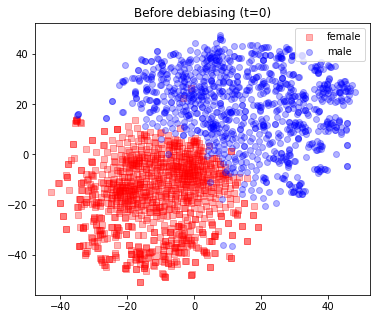

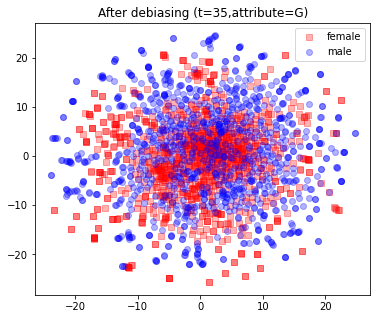

V-measure-before (TSNE space): 0.8302090145173925
V-measure-after (TSNE space): 0.002762405417136879
V-measure-before (original embedding space): 1.0
V-measure-after (original embedding space): 0.00024443804672199816
Rank before: 300; Rank after: 210


In [18]:
ind2label_g =  {0: "female", 1: "male"}

#only debias and color on gender
tSNE_and_vmeasure("G", P_g, ind2label_g, plot_gender_vecs, plot_gender_labels, k=2)

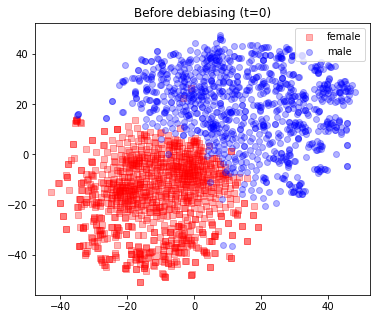

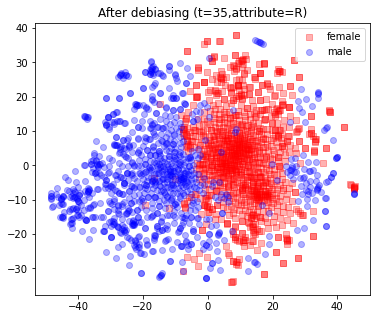

V-measure-before (TSNE space): 0.8302090145173925
V-measure-after (TSNE space): 0.5300372005749892
V-measure-before (original embedding space): 1.0
V-measure-after (original embedding space): 0.7794880012002317
Rank before: 300; Rank after: 204


In [15]:
#debias: race; color and draw: gender
tSNE_and_vmeasure("R", P_r, ind2label_g, plot_gender_vecs, plot_gender_labels, k=2)


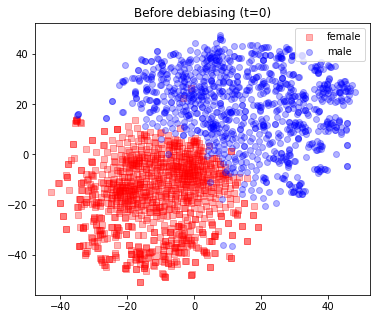

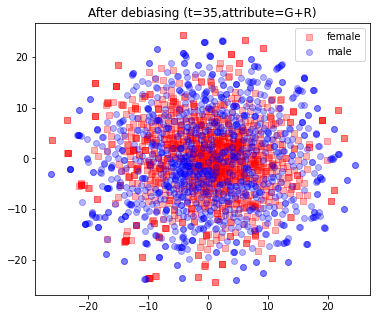

V-measure-before (TSNE space): 0.8302090145173925
V-measure-after (TSNE space): 0.0008174966818348295
V-measure-before (original embedding space): 1.0
V-measure-after (original embedding space): 0.000439906665082654
Rank before: 300; Rank after: 114


In [16]:
#debias: race+gender; color and draw: gender
tSNE_and_vmeasure("G+R", P_gr, ind2label_g, plot_gender_vecs, plot_gender_labels, k=2)


#### plot color on race

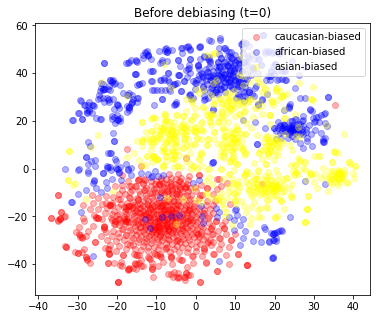

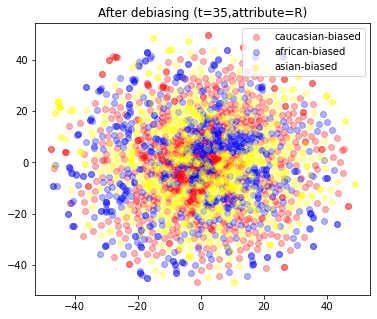

V-measure-before (TSNE space): 0.4247251906049363
V-measure-after (TSNE space): 0.0008219707782990943
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.0026519363536194177
Rank before: 300; Rank after: 204


In [20]:
ind2label_race =  {1: "caucasian-biased", 2: "african-biased", 3: "asian-biased"}
tSNE_and_vmeasure("R", P_r, ind2label_race, plot_race_vecs, plot_race_labels)


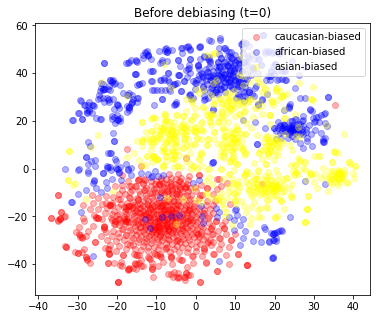

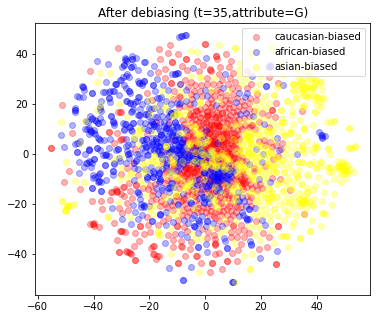

V-measure-before (TSNE space): 0.4247251906049363
V-measure-after (TSNE space): 0.14333594238052427
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.4592623985605829
Rank before: 300; Rank after: 210


In [21]:
tSNE_and_vmeasure("G", P_g, ind2label_race, plot_race_vecs, plot_race_labels)

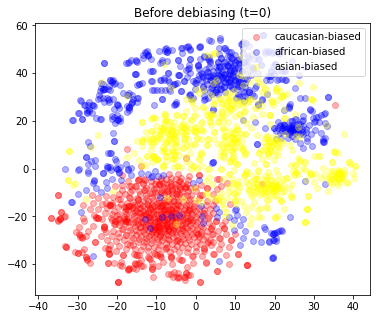

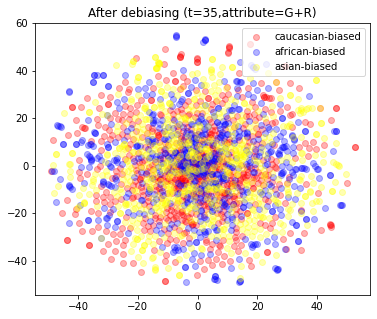

V-measure-before (TSNE space): 0.4247251906049363
V-measure-after (TSNE space): 0.0013373417214626992
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.00022825605093225324
Rank before: 300; Rank after: 114


In [22]:
tSNE_and_vmeasure("G+R", P_gr, ind2label_race, plot_race_vecs, plot_race_labels)

### Debias on each classifier and combinations of classifiers

In [25]:
rowspace_projections_w=[]
for W in Ws_r:
    W_w=W[0,:].reshape((1,300))
    P_rowspace_wi = debias.get_rowspace_projection(W_w)
    rowspace_projections_w.append(P_rowspace_wi)
P_w = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_w, 300)    

In [28]:
rowspace_projections_b=[]
for W in Ws_r:
    W_b=W[1,:].reshape((1,300))
    P_rowspace_wi = debias.get_rowspace_projection(W_b)
    rowspace_projections_b.append(P_rowspace_wi)
P_b = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_b, 300)    

In [31]:
rowspace_projections_y=[]
for W in Ws_r:
    W_y=W[2,:].reshape((1,300))
    P_rowspace_wi = debias.get_rowspace_projection(W_y)
    rowspace_projections_y.append(P_rowspace_wi)
P_y = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_y, 300)    

In [71]:
rowspace_projections_n=[]
for W in Ws_g:
    W_n=W[0,:].reshape((1,300))
    P_rowspace_wi = debias.get_rowspace_projection(W_n)
    rowspace_projections_n.append(P_rowspace_wi)
P_n = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_n, 300)    

In [68]:
rowspace_projections_f=[]
for W in Ws_g:
    W_f=W[1,:].reshape((1,300))
    P_rowspace_wi = debias.get_rowspace_projection(W_f)
    rowspace_projections_f.append(P_rowspace_wi)
P_f = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_f, 300)    

In [72]:
rowspace_projections_m=[]
for W in Ws_g:
    W_m=W[2,:].reshape((1,300))
    P_rowspace_wi = debias.get_rowspace_projection(W_m)
    rowspace_projections_m.append(P_rowspace_wi)
P_m = debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_m, 300)    

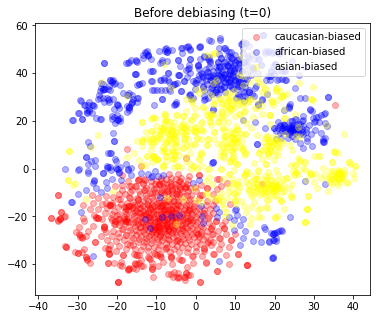

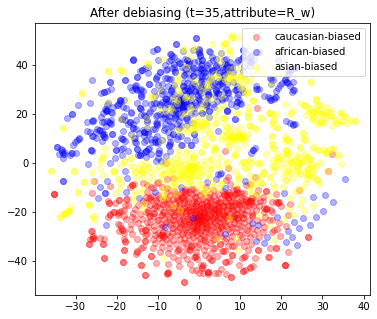

V-measure-before (TSNE space): 0.4247251906049363
V-measure-after (TSNE space): 0.46161938376558437
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.42235702816730325
Rank before: 300; Rank after: 270


In [27]:
tSNE_and_vmeasure("R_w", P_w, ind2label_race, plot_race_vecs, plot_race_labels)

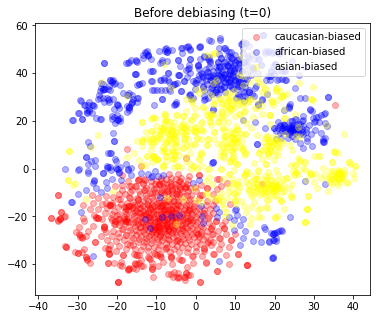

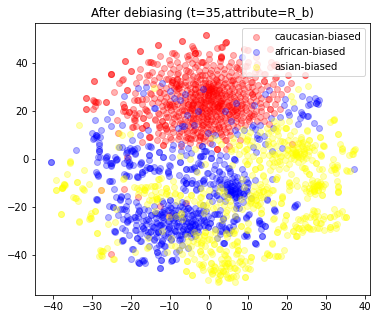

V-measure-before (TSNE space): 0.4247251906049363
V-measure-after (TSNE space): 0.4248125229758682
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.48884077735283316
Rank before: 300; Rank after: 268


In [29]:
tSNE_and_vmeasure("R_b", P_b, ind2label_race, plot_race_vecs, plot_race_labels)

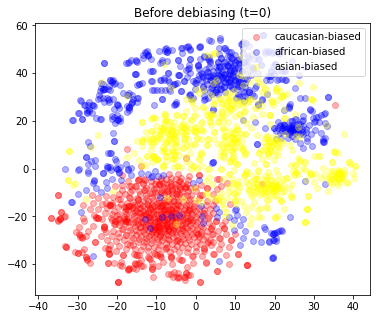

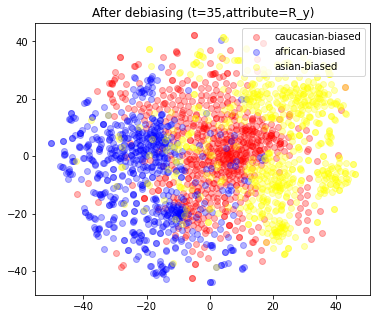

V-measure-before (TSNE space): 0.4247251906049363
V-measure-after (TSNE space): 0.19700113567573208
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.3355213611720912
Rank before: 300; Rank after: 267


In [32]:
tSNE_and_vmeasure("R_y", P_y, ind2label_race, plot_race_vecs, plot_race_labels)

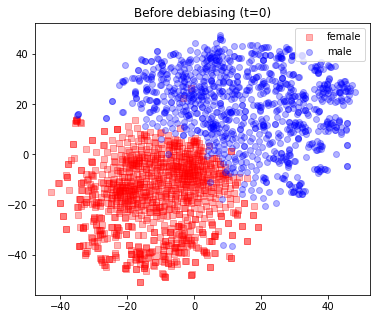

V-measure-before (TSNE space): 0.5965463829476698
V-measure-before (original embedding space): 0.8031367147555022
Rank before: 300


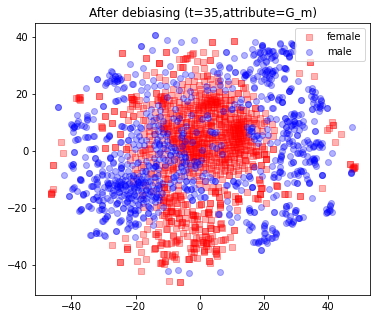

V-measure-after (TSNE space): 0.019574799338191274
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.29262650386928546
Rank before: 300; Rank after: 270


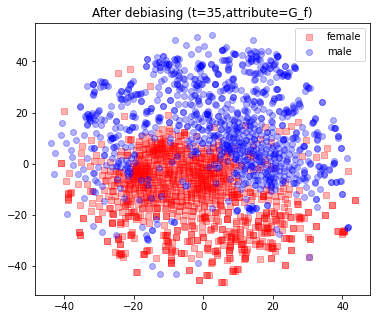

V-measure-after (TSNE space): 0.22810603489348263
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.17837676814066547
Rank before: 300; Rank after: 270


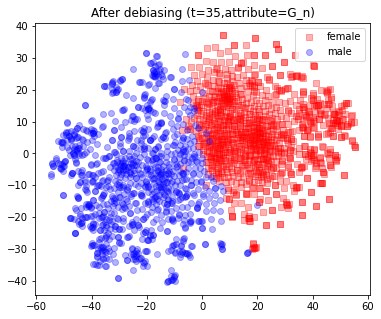

V-measure-after (TSNE space): 0.5234256501887956
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.8044936597482205
Rank before: 300; Rank after: 270


In [73]:
tSNE_and_vmeasure_before(ind2label_g, plot_gender_vecs, plot_gender_labels)
tSNE_and_vmeasure_after("G_m", P_m, ind2label_g, plot_gender_vecs, plot_gender_labels)
tSNE_and_vmeasure_after("G_f", P_f, ind2label_g, plot_gender_vecs, plot_gender_labels)
tSNE_and_vmeasure_after("G_n", P_n, ind2label_g, plot_gender_vecs, plot_gender_labels)

In [75]:
rowspace_projections_mf=np.concatenate((rowspace_projections_m,rowspace_projections_f),axis=0)
P_mf=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_mf, 300)

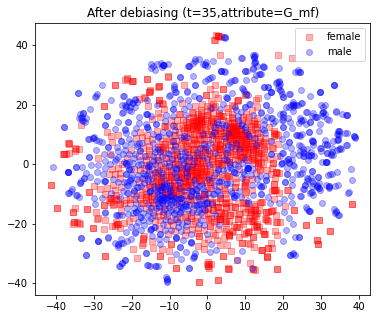

V-measure-after (TSNE space): 0.0027569036575244873
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.03252796167909834
Rank before: 300; Rank after: 240


In [76]:
tSNE_and_vmeasure_after("G_mf", P_mf, ind2label_g, plot_gender_vecs, plot_gender_labels)

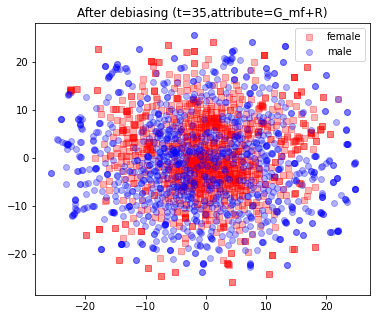

V-measure-after (TSNE space): 0.008744855321802516
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.00036546669770605477
Rank before: 300; Rank after: 144


In [77]:
rowspace_projections_mfr=np.concatenate((rowspace_projections_mf,rowspace_projs_r),axis=0)
P_mfr=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_mfr, 300)
tSNE_and_vmeasure_after("G_mf+R", P_mfr, ind2label_g, plot_gender_vecs, plot_gender_labels)

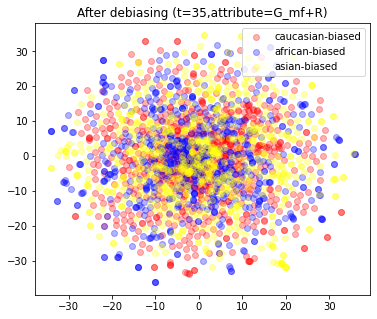

V-measure-after (TSNE space): 0.0020298403445269987
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.001068193660659832
Rank before: 300; Rank after: 144


In [78]:
tSNE_and_vmeasure_after("G_mf+R", P_mfr, ind2label_race, plot_race_vecs, plot_race_labels)

In [35]:
rowspace_projections_g_w=np.concatenate((rowspace_projs_g,rowspace_projections_w),axis=0)
P_g_w=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_g_w, 300)

#same with P_g_w
# rowspace_projections_w_g=np.concatenate((rowspace_projections_w, rowspace_projs_g),axis=0)
# P_w_g=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_w_g, 300)

rowspace_projections_g_b=np.concatenate((rowspace_projs_g,rowspace_projections_b),axis=0)
P_g_b=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_g_b, 300)

rowspace_projections_g_y=np.concatenate((rowspace_projs_g,rowspace_projections_y),axis=0)
P_g_y=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_g_y, 300)

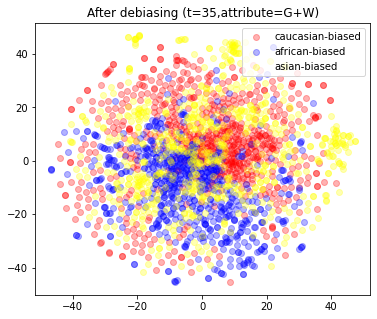

V-measure-after (TSNE space): 0.09861461154815795
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.3764855525442348
Rank before: 300; Rank after: 180


In [39]:
tSNE_and_vmeasure_after("G+W", P_g_w, ind2label_race, plot_race_vecs, plot_race_labels)

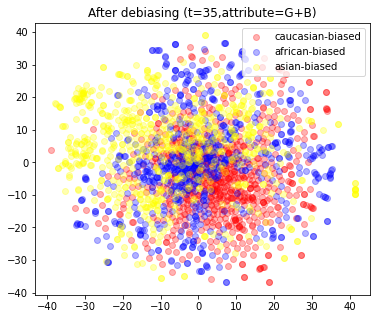

V-measure-after (TSNE space): 0.05602097315022494
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.17377668912841507
Rank before: 300; Rank after: 178


In [41]:
tSNE_and_vmeasure_after("G+B", P_g_b, ind2label_race, plot_race_vecs, plot_race_labels)

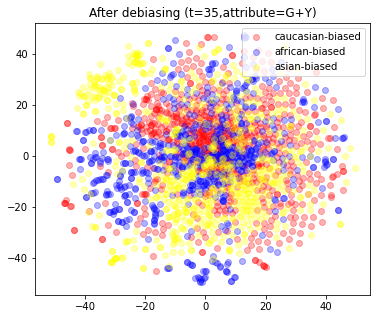

V-measure-after (TSNE space): 0.014829694701964938
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.13380774879615856
Rank before: 300; Rank after: 177


In [42]:
tSNE_and_vmeasure_after("G+Y", P_g_y, ind2label_race, plot_race_vecs, plot_race_labels)

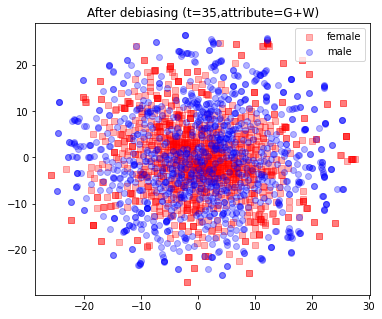

V-measure-after (TSNE space): 0.0014447268332078156
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 6.019488663049962e-05
Rank before: 300; Rank after: 180


In [45]:
tSNE_and_vmeasure_after("G+W", P_g_w, ind2label_g, plot_gender_vecs, plot_gender_labels)

In [46]:
rowspace_projections_wb=np.concatenate((rowspace_projections_w,rowspace_projections_b),axis=0)
P_wb=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_wb, 300)

rowspace_projections_wy=np.concatenate((rowspace_projections_w,rowspace_projections_y),axis=0)
P_wy=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_wy, 300)

rowspace_projections_by=np.concatenate((rowspace_projections_b,rowspace_projections_y),axis=0)
P_by=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_by, 300)

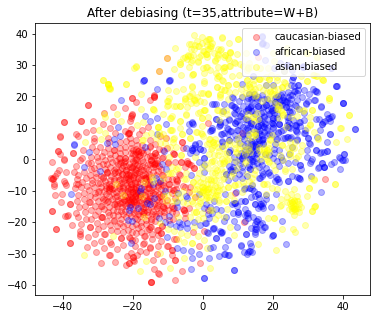

V-measure-after (TSNE space): 0.3585892873651697
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.3767920640052556
Rank before: 300; Rank after: 238


In [55]:
tSNE_and_vmeasure_after("W+B", P_wb, ind2label_race, plot_race_vecs, plot_race_labels)

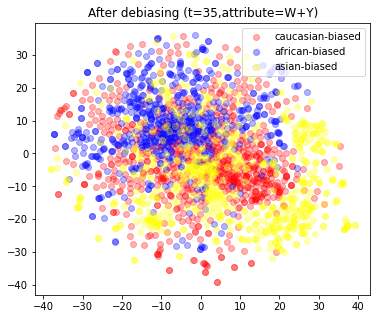

V-measure-after (TSNE space): 0.13686174858282385
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.18807087602802408
Rank before: 300; Rank after: 237


In [56]:
tSNE_and_vmeasure_after("W+Y", P_wy, ind2label_race, plot_race_vecs, plot_race_labels)

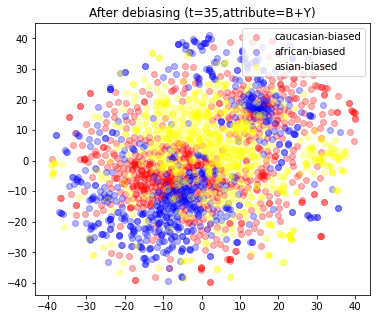

V-measure-after (TSNE space): 0.0603367367965844
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.20477916275614866
Rank before: 300; Rank after: 235


In [57]:
tSNE_and_vmeasure_after("B+Y", P_by, ind2label_race, plot_race_vecs, plot_race_labels)

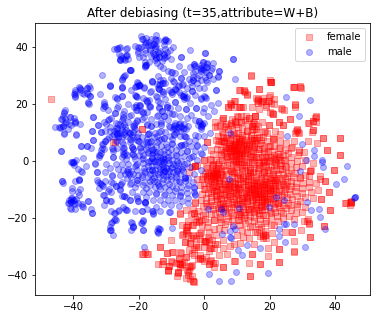

V-measure-after (TSNE space): 0.46365048857061725
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.6324268940513752
Rank before: 300; Rank after: 238


In [58]:
tSNE_and_vmeasure_after("W+B", P_wb, ind2label_g, plot_gender_vecs, plot_gender_labels)

In [61]:
rowspace_projections_gwb=np.concatenate((rowspace_projs_g, rowspace_projections_w,rowspace_projections_b),axis=0)
P_gwb=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_gwb, 300)

rowspace_projections_gwy=np.concatenate((rowspace_projs_g, rowspace_projections_w,rowspace_projections_y),axis=0)
P_gwy=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_gwy, 300)

rowspace_projections_gby=np.concatenate((rowspace_projs_g, rowspace_projections_b,rowspace_projections_y),axis=0)
P_gby=debias.get_projection_to_intersection_of_nullspaces(rowspace_projections_gby, 300)

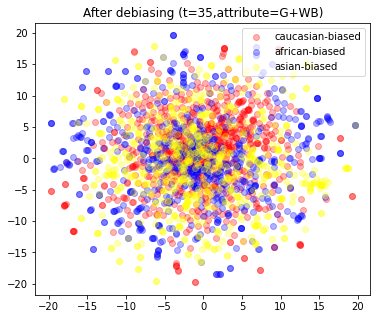

V-measure-after (TSNE space): 0.006123970910351767
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.008542434388266207
Rank before: 300; Rank after: 148


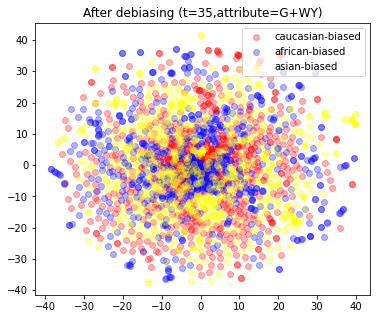

V-measure-after (TSNE space): 0.003193337330394195
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.009894054165275838
Rank before: 300; Rank after: 147


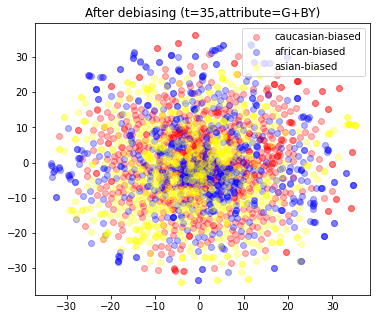

V-measure-after (TSNE space): 0.00749336352522995
V-measure-before (original embedding space): 0.5713071587804308
V-measure-after (original embedding space): 0.0030275442212118315
Rank before: 300; Rank after: 145


In [63]:
tSNE_and_vmeasure_after("G+WB", P_gwb, ind2label_race, plot_race_vecs, plot_race_labels)
tSNE_and_vmeasure_after("G+WY", P_gwy, ind2label_race, plot_race_vecs, plot_race_labels)
tSNE_and_vmeasure_after("G+BY", P_gby, ind2label_race, plot_race_vecs, plot_race_labels)

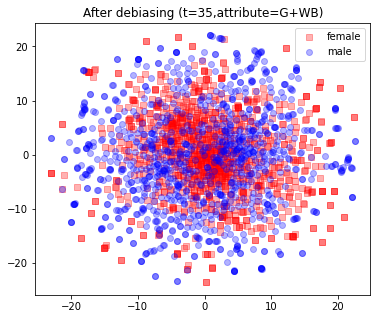

V-measure-after (TSNE space): 0.0016342042515629137
V-measure-before (original embedding space): 0.8031367147555022
V-measure-after (original embedding space): 0.0009405002782780735
Rank before: 300; Rank after: 148


In [65]:
tSNE_and_vmeasure_after("G+WB", P_gwb, ind2label_g, plot_gender_vecs, plot_gender_labels)

In [64]:
rank_P_race = np.linalg.matrix_rank(P_r)
rank_P_g = np.linalg.matrix_rank(P_g)
rank_P_gr = np.linalg.matrix_rank(P_gr)

rank_Pw = np.linalg.matrix_rank(P_w)
rank_Pb = np.linalg.matrix_rank(P_b)
rank_Py = np.linalg.matrix_rank(P_y)

rank_P_wb = np.linalg.matrix_rank(P_wb)
rank_P_wy = np.linalg.matrix_rank(P_wy)
rank_P_by = np.linalg.matrix_rank(P_by)

rank_P_gw = np.linalg.matrix_rank(P_g_w)
rank_P_gb = np.linalg.matrix_rank(P_g_b)
rank_P_gy = np.linalg.matrix_rank(P_g_y)

rank_P_gwb = np.linalg.matrix_rank(P_gwb)
rank_P_gwy = np.linalg.matrix_rank(P_gwy)
rank_P_gby = np.linalg.matrix_rank(P_gby)


print(rank_P_race,rank_P_g,rank_P_gr)
print(rank_Pw,rank_Pb,rank_Py)
print(rank_P_wb,rank_P_wy,rank_P_by)
print(rank_P_gw,rank_P_gb,rank_P_gy)
print(rank_P_gwb,rank_P_gwy,rank_P_gby)

204 210 114
270 268 267
238 237 235
180 178 177
148 147 145


In [66]:
print(300-rank_P_race,300-rank_P_g,300-rank_P_gr)
print(300-rank_Pw,300-rank_Pb,300-rank_Py)
print(300-rank_P_wb,300-rank_P_wy,300-rank_P_by)
print(300-rank_P_gw,300-rank_P_gb,300-rank_P_gy)
print(300-rank_P_gwb,300-rank_P_gwy,300-rank_P_gby)

96 90 186
30 32 33
62 63 65
120 122 123
152 153 155


### Successive G+R

### intersaction group

In [ ]:
num_vectors_per_class = 7500

def assign_direction_and_labels_inter(model, by_pca=False):
    white_vecs, black_vecs, yellow_vecs,\
    ind2label_race, plot_race_vecs, plot_race_labels=assign_3labels_race(model, by_pca=False)
